### 

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import yfinance as yf
import statsmodels.api as sm
import xlwings as xw

In [2]:
# Helpers

def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return v, correlation

In [3]:
# Parameters
report_year = 2020
ls_factors_full = ['Economic Growth', 'Real Rate', 'Inflation' , 'Private Specific']
ls_pub_factor = ls_factors_full[:-1]
ls_priv_factor = ls_factors_full[-1]

In [4]:
ls_pub_factor

['Economic Growth', 'Real Rate', 'Inflation']

In [5]:
# CMAs

data_sheet = xw.Book(r'CMA_survey_by_HAS.xlsx').sheets(str(report_year))

result_sheet = xw.Book(r'CMA_survey_by_HAS.xlsx').sheets('exported_result')


df_CMAs_raw = data_sheet['A1'].expand().options(pd.DataFrame).value
df_CMAs_raw.set_index('Asset Class', inplace=True)


### CMA survey produced by Horizon Actuarial Services (HAS)

In [6]:
df_CMAs_raw

,10Y-Arith-Return,10Y-Geom-Return,20Y-Arith-Return,20Y-Geom-Return,Std Dev,1.0,2.0,3.0,4.0,5.0,...,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0
Asset Class,,,,,,,,,,,,,,,,,,,,,
US Equity-Large Cap,0.0740,0.0616,0.0836,0.0706,0.1622,1.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
US Equity-Small/Mid Cap,0.0876,0.0685,0.0954,0.0756,0.2022,0.89,1.00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Non-US Equity-Developed,0.0833,0.0680,0.0909,0.0748,0.1805,0.84,0.76,1.00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Non-US Equity-Emerging,0.1059,0.0785,0.1133,0.0842,0.2423,0.73,0.69,0.80,1.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
US Corporate Bonds-Core,0.0275,0.0260,0.0374,0.0356,0.0547,0.15,0.08,0.17,0.16,1.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
US Corporate Bonds-Long Duration,0.0313,0.0270,0.0411,0.0356,0.1016,0.14,0.07,0.14,0.11,0.86,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
US Corporate Bonds-High Yield,0.0536,0.0490,0.0614,0.0562,0.0975,0.63,0.62,0.62,0.62,0.38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Non-US Debt-Developed,0.0158,0.0139,0.0253,0.0226,0.0702,0.12,0.06,0.28,0.23,0.53,...,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Non-US Debt-Emerging,0.0576,0.0516,0.0654,0.0585,0.1097,0.48,0.44,0.52,0.62,0.44,...,0.41,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Define the asset class used in the report

In [7]:
ls_asset_classes = df_CMAs_raw.index.to_list()
inscope_asset_classes = ['US Equity-Large Cap',
                         'Non-US Equity-Developed',
                         'Non-US Equity-Emerging',
                         'US Corporate Bonds-Core',
                         'US Corporate Bonds-Long Duration',
                         'US Corporate Bonds-High Yield',
                         'Non-US Debt-Developed',
                         'Non-US Debt-Emerging',
                         'TIPS (Inflation-Protected)',
                         'Commodities',
                         'Hedge Funds',
                         'Real Estate',
                         'Infrastructure',
                         'Private Equity']
ordered_asset_classes = df_CMAs_raw[df_CMAs_raw.index.isin(inscope_asset_classes)].index.to_list()


### Extract the return and std dev matrix

In [8]:
df_CMAs_Returns = df_CMAs_raw[df_CMAs_raw.index.isin(ordered_asset_classes)][['10Y-Arith-Return','10Y-Geom-Return','20Y-Arith-Return','20Y-Geom-Return','Std Dev']].copy()
df_CMAs_Returns.head()

,10Y-Arith-Return,10Y-Geom-Return,20Y-Arith-Return,20Y-Geom-Return,Std Dev
Asset Class,,,,,
US Equity-Large Cap,0.0740,0.0616,0.0836,0.0706,0.1622
Non-US Equity-Developed,0.0833,0.0680,0.0909,0.0748,0.1805
Non-US Equity-Emerging,0.1059,0.0785,0.1133,0.0842,0.2423
US Corporate Bonds-Core,0.0275,0.0260,0.0374,0.0356,0.0547
US Corporate Bonds-Long Duration,0.0313,0.0270,0.0411,0.0356,0.1016


### Extract the correlation matrix

In [9]:
# Extract asset correlation matrix
df_Corr_a = df_CMAs_raw.iloc[:-1 , -17:]

df_Corr_a.set_axis(df_Corr_a.index, axis=1, inplace=True)


df_Corr_a.fillna(0.0, inplace=True)
df_Corr_a = df_Corr_a + df_Corr_a.T - np.diag(np.diag(df_Corr_a))

df_Corr_a = df_Corr_a[df_Corr_a.index.isin(ordered_asset_classes)][ordered_asset_classes] #keep only the inscope assets

df_Corr_a

Asset Class,US Equity-Large Cap,Non-US Equity-Developed,Non-US Equity-Emerging,US Corporate Bonds-Core,US Corporate Bonds-Long Duration,US Corporate Bonds-High Yield,Non-US Debt-Developed,Non-US Debt-Emerging,TIPS (Inflation-Protected),Real Estate,Hedge Funds,Commodities,Infrastructure,Private Equity
Asset Class,,,,,,,,,,,,,,
US Equity-Large Cap,1.00,0.84,0.73,0.15,0.14,0.63,0.12,0.48,0.05,0.53,0.63,0.31,0.53,0.73
Non-US Equity-Developed,0.84,1.00,0.80,0.17,0.14,0.62,0.28,0.52,0.09,0.49,0.63,0.39,0.56,0.67
Non-US Equity-Emerging,0.73,0.80,1.00,0.16,0.11,0.62,0.23,0.62,0.13,0.44,0.61,0.42,0.51,0.59
US Corporate Bonds-Core,0.15,0.17,0.16,1.00,0.86,0.38,0.53,0.44,0.67,0.22,0.15,0.08,0.25,0.04
US Corporate Bonds-Long Duration,0.14,0.14,0.11,0.86,1.00,0.32,0.49,0.36,0.54,0.18,0.11,0.01,0.25,0.04
US Corporate Bonds-High Yield,0.63,0.62,0.62,0.38,0.32,1.00,0.24,0.62,0.27,0.46,0.53,0.35,0.53,0.51
Non-US Debt-Developed,0.12,0.28,0.23,0.53,0.49,0.24,1.00,0.41,0.45,0.19,0.13,0.21,0.28,0.07
Non-US Debt-Emerging,0.48,0.52,0.62,0.44,0.36,0.62,0.41,1.00,0.36,0.36,0.43,0.30,0.45,0.36
TIPS (Inflation-Protected),0.05,0.09,0.13,0.67,0.54,0.27,0.45,0.36,1.00,0.17,0.10,0.22,0.20,0.01


### Create Covariance Matrix by

$$\Sigma_a=diag(\sigma_X) \times Corr_{XX} \times diag(\sigma_X)$$

In [10]:
# Compute Covariance Matrix
df_diag_std = np.diag(df_CMAs_Returns['Std Dev'])

df_Sigma_a = pd.DataFrame(df_diag_std.dot(df_Corr_a).dot(df_diag_std))

df_Sigma_a.set_axis(ordered_asset_classes, axis=1, inplace=True)
df_Sigma_a.set_axis(ordered_asset_classes, axis=0, inplace=True)

df_Sigma_a.round(4)

,US Equity-Large Cap,Non-US Equity-Developed,Non-US Equity-Emerging,US Corporate Bonds-Core,US Corporate Bonds-Long Duration,US Corporate Bonds-High Yield,Non-US Debt-Developed,Non-US Debt-Emerging,TIPS (Inflation-Protected),Real Estate,Hedge Funds,Commodities,Infrastructure,Private Equity
US Equity-Large Cap,0.0263,0.0246,0.0287,0.0013,0.0023,0.0100,0.0014,0.0085,0.0005,0.0145,0.0082,0.0088,0.0125,0.0260
Non-US Equity-Developed,0.0246,0.0326,0.0350,0.0017,0.0026,0.0109,0.0035,0.0103,0.0010,0.0149,0.0091,0.0124,0.0147,0.0266
Non-US Equity-Emerging,0.0287,0.0350,0.0587,0.0021,0.0027,0.0146,0.0039,0.0165,0.0019,0.0180,0.0118,0.0179,0.0180,0.0314
US Corporate Bonds-Core,0.0013,0.0017,0.0021,0.0030,0.0048,0.0020,0.0020,0.0026,0.0022,0.0020,0.0007,0.0008,0.0020,0.0005
US Corporate Bonds-Long Duration,0.0023,0.0026,0.0027,0.0048,0.0103,0.0032,0.0035,0.0040,0.0033,0.0031,0.0009,0.0002,0.0037,0.0009
US Corporate Bonds-High Yield,0.0100,0.0109,0.0146,0.0020,0.0032,0.0095,0.0016,0.0066,0.0016,0.0076,0.0041,0.0060,0.0075,0.0109
Non-US Debt-Developed,0.0014,0.0035,0.0039,0.0020,0.0035,0.0016,0.0049,0.0032,0.0019,0.0022,0.0007,0.0026,0.0029,0.0011
Non-US Debt-Emerging,0.0085,0.0103,0.0165,0.0026,0.0040,0.0066,0.0032,0.0120,0.0024,0.0067,0.0038,0.0058,0.0072,0.0087
TIPS (Inflation-Protected),0.0005,0.0010,0.0019,0.0022,0.0033,0.0016,0.0019,0.0024,0.0037,0.0017,0.0005,0.0023,0.0018,0.0001
Real Estate,0.0145,0.0149,0.0180,0.0020,0.0031,0.0076,0.0022,0.0067,0.0017,0.0284,0.0050,0.0068,0.0098,0.0170


In [40]:
import seaborn as sn

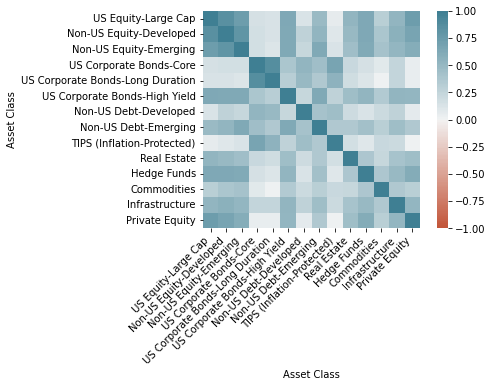

In [45]:
import matplotlib.pyplot as plt

ax = sn.heatmap(
    df_Corr_a, 
    vmin=-1, vmax=1, center=0,
    cmap=sn.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

In [36]:
df_diag_std

array([[0.1622, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.1805, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.2423, 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.0547, 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.1016, 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    , 0.0975, 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.0702, 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.1097,
        0.    , 0.    , 0

 ### Factor-Mimicking Portfolio Definition: $\omega_{mf}$ and $\hat{\omega}_{pf}$

In [11]:
# Economic Growth Factor

weights = np.zeros((14,4), float)

df_public_weights = pd.DataFrame(weights,columns=ls_factors_full)
df_public_weights.set_axis(ordered_asset_classes, axis=0, inplace=True)

df_public_weights.loc['US Equity-Large Cap', 'Economic Growth'] = 0.25
df_public_weights.loc['Non-US Equity-Developed', 'Economic Growth'] = 0.20
df_public_weights.loc['Non-US Equity-Emerging', 'Economic Growth'] = 0.10
df_public_weights.loc['Commodities', 'Economic Growth'] = 0.10

df_public_weights.loc['TIPS (Inflation-Protected)','Real Rate'] = 1.65

df_public_weights.loc['US Corporate Bonds-Core','Inflation'] = -1.60
df_public_weights.loc['TIPS (Inflation-Protected)','Inflation'] = 1.60
df_public_weights.loc['Commodities','Inflation'] = 0.30

df_public_weights.loc['Real Estate','Private Specific'] = 0.4
df_public_weights.loc['Infrastructure','Private Specific'] = 0.4
df_public_weights.loc['Private Equity','Private Specific'] = 0.4

df_public_weights

,Economic Growth,Real Rate,Inflation,Private Specific
US Equity-Large Cap,0.25,0.00,0.0,0.0
Non-US Equity-Developed,0.20,0.00,0.0,0.0
Non-US Equity-Emerging,0.10,0.00,0.0,0.0
US Corporate Bonds-Core,0.00,0.00,-1.6,0.0
US Corporate Bonds-Long Duration,0.00,0.00,0.0,0.0
US Corporate Bonds-High Yield,0.00,0.00,0.0,0.0
Non-US Debt-Developed,0.00,0.00,0.0,0.0
Non-US Debt-Emerging,0.00,0.00,0.0,0.0
TIPS (Inflation-Protected),0.00,1.65,1.6,0.0
Real Estate,0.00,0.00,0.0,0.4


### Compute $\beta_{mf}$ as

$$\beta_{mf}=\Sigma_a \omega_{mf}(\omega_{mf}^{\prime} \Sigma_a \omega_{mf})^{-1}$$

This definition of factor loadings is none other than an estimate of those factor loadings using a time-series regression.

In [12]:
# Compute beta mf

df_omega_mf = df_public_weights[ls_pub_factor]

df_beta_mf = df_Sigma_a.dot(df_omega_mf).dot(np.linalg.inv(df_omega_mf.T.dot(df_Sigma_a).dot(df_omega_mf)))

df_beta_mf.set_axis(ls_pub_factor, axis=1, inplace=True)

round(df_beta_mf,2)

,Economic Growth,Real Rate,Inflation
US Equity-Large Cap,1.52,0.03,-0.27
Non-US Equity-Developed,1.71,0.05,-0.20
Non-US Equity-Emerging,2.10,0.09,-0.08
US Corporate Bonds-Core,0.13,0.56,-0.41
US Corporate Bonds-Long Duration,0.20,0.88,-0.72
US Corporate Bonds-High Yield,0.66,0.28,-0.20
Non-US Debt-Developed,0.16,0.38,-0.17
Non-US Debt-Emerging,0.62,0.44,-0.24
TIPS (Inflation-Protected),-0.00,0.61,-0.00
Real Estate,0.89,0.28,-0.21


### Compute the private-speicific factor-mimicking portfolio wieights $\omega_{pf}$ as

$$\omega_{pf}=\hat{\omega}_{pf}-\omega_{mf} \beta_{mf}^{\prime} \hat{\omega}_{pf}$$

In [13]:
df_hat_omega_pf = df_public_weights[[ls_priv_factor]]

df_omega_pf = df_hat_omega_pf - df_omega_mf.dot(df_beta_mf.T).dot(df_hat_omega_pf)

df_omega_pf.round(2)

,Private Specific
US Equity-Large Cap,-0.33
Non-US Equity-Developed,-0.26
Non-US Equity-Emerging,-0.13
US Corporate Bonds-Core,-0.21
US Corporate Bonds-Long Duration,0.00
US Corporate Bonds-High Yield,0.00
Non-US Debt-Developed,0.00
Non-US Debt-Emerging,0.00
TIPS (Inflation-Protected),-0.03
Real Estate,0.40


#### Compute $\beta_f$ as

$$\beta_{f}=\Sigma_a \omega_{f}(\omega_{f}^{\prime} \Sigma_a \omega_{f})^{-1} \circ I$$

Where

$$\omega_f:=[\omega_{mf}\omega_{pf}]$$

In [14]:
# define omega f
df_omega_f = df_omega_mf.join(df_omega_pf)
df_omega_f.round(2)

,Economic Growth,Real Rate,Inflation,Private Specific
US Equity-Large Cap,0.25,0.00,0.0,-0.33
Non-US Equity-Developed,0.20,0.00,0.0,-0.26
Non-US Equity-Emerging,0.10,0.00,0.0,-0.13
US Corporate Bonds-Core,0.00,0.00,-1.6,-0.21
US Corporate Bonds-Long Duration,0.00,0.00,0.0,0.00
US Corporate Bonds-High Yield,0.00,0.00,0.0,0.00
Non-US Debt-Developed,0.00,0.00,0.0,0.00
Non-US Debt-Emerging,0.00,0.00,0.0,0.00
TIPS (Inflation-Protected),0.00,1.65,1.6,-0.03
Real Estate,0.00,0.00,0.0,0.40


In [15]:
# define I I_{pf} is N x 1 vector where an entry is equal 1 for all private assets and 0 otherwise
# set to 1 for Real Estate, Infrastructure and Private Equity

i = np.zeros((14,4)) + 1
i[:,3] = 0
i[(-5, -2, -1),3] = 1
i

array([[1., 1., 1., 0.],
       [1., 1., 1., 0.],
       [1., 1., 1., 0.],
       [1., 1., 1., 0.],
       [1., 1., 1., 0.],
       [1., 1., 1., 0.],
       [1., 1., 1., 0.],
       [1., 1., 1., 0.],
       [1., 1., 1., 0.],
       [1., 1., 1., 1.],
       [1., 1., 1., 0.],
       [1., 1., 1., 0.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]])

In [16]:
# compute beta f

df_Sigma_f = df_omega_f.T.dot(df_Sigma_a).dot(df_omega_f)

df_beta_f = df_Sigma_a.dot(df_omega_f).dot(np.linalg.inv(df_Sigma_f))
df_beta_f = df_beta_f.multiply(i)

df_beta_f.set_axis(ls_factors_full, axis=1, inplace=True)

df_beta_f.round(2)

,Economic Growth,Real Rate,Inflation,Private Specific
US Equity-Large Cap,1.52,0.03,-0.27,0.00
Non-US Equity-Developed,1.71,0.05,-0.20,-0.00
Non-US Equity-Emerging,2.10,0.09,-0.08,-0.00
US Corporate Bonds-Core,0.13,0.56,-0.41,-0.00
US Corporate Bonds-Long Duration,0.20,0.88,-0.72,0.00
US Corporate Bonds-High Yield,0.66,0.28,-0.20,0.00
Non-US Debt-Developed,0.16,0.38,-0.17,-0.00
Non-US Debt-Emerging,0.62,0.44,-0.24,0.00
TIPS (Inflation-Protected),0.00,0.61,0.00,0.00
Real Estate,0.89,0.28,-0.21,0.86


### Factor volatility and correlations from factor covariance matrixes

In [17]:
# factor covariance matrix
df_Sigma_f


,Economic Growth,Real Rate,Inflation,Private Specific
Economic Growth,1.043393e-02,1.227688e-03,2.532207e-03,0.000000e+00
Real Rate,1.227688e-03,9.965031e-03,4.969049e-03,8.131516e-19
Inflation,2.532207e-03,4.969049e-03,9.974925e-03,1.653408e-18
Private Specific,2.846031e-18,1.216877e-18,1.609433e-18,1.157771e-02


In [18]:
# compute std and correlation from covariance matrix

df_factor_std, df_factor_correlation_matrix = correlation_from_covariance(df_Sigma_f)
df_factor_std = pd.DataFrame(df_factor_std,index=df_Sigma_f.columns)

In [19]:
# volatility
df_factor_std.round(4)

,0
Economic Growth,0.1021
Real Rate,0.0998
Inflation,0.0999
Private Specific,0.1076


In [20]:
# factor correlation matrix
df_factor_correlation_matrix.round(2)

,Economic Growth,Real Rate,Inflation,Private Specific
Economic Growth,1.00,0.12,0.25,0.0
Real Rate,0.12,1.00,0.50,0.0
Inflation,0.25,0.50,1.00,0.0
Private Specific,0.00,0.00,0.00,1.0


### Estimating the Factor Risk Premiums

Approach 1:
$$\mu_f = \omega_f^{\prime}\mu_a$$

Where
$$\mu_a=expected\ return - 10\ yr\ treasury$$

Approach 2:
$$\mu_{a,pub}=c_m+\beta_{mf,pub}\mu_{mf^*}+\epsilon$$
$$\mu_{a,priv}-\beta_{mf,priv}\mu_{mf^*}=c_p+\beta_{mf,priv}\mu_{pf^*}+\eta$$

In [37]:
# Risk Premium
# Approach 1
risk_free_rate = 0.0156

df_a_excess_returns = df_CMAs_Returns[['10Y-Geom-Return']] - risk_free_rate
df_f_excess_returns = df_omega_f.T.dot( df_a_excess_returns )

df_f_excess_returns.round(3)

,10Y-Geom-Return
Economic Growth,0.030
Real Rate,0.007
Inflation,-0.005
Private Specific,0.027


In [22]:
# Approach 2
ls_pub = ['US Equity-Large Cap','Non-US Equity-Developed','Non-US Equity-Emerging','US Corporate Bonds-Core','US Corporate Bonds-Long Duration','US Corporate Bonds-High Yield','Non-US Debt-Developed','Non-US Debt-Emerging','TIPS (Inflation-Protected)','Commodities']

df_mu_a_pub = df_CMAs_Returns[df_CMAs_Returns.index.isin(ls_pub)][['10Y-Geom-Return']]
df_beta_mf_pub = df_beta_mf[df_beta_mf.index.isin(ls_pub)]

df_beta_mf_pub.round(2)

,Economic Growth,Real Rate,Inflation
US Equity-Large Cap,1.52,0.03,-0.27
Non-US Equity-Developed,1.71,0.05,-0.20
Non-US Equity-Emerging,2.10,0.09,-0.08
US Corporate Bonds-Core,0.13,0.56,-0.41
US Corporate Bonds-Long Duration,0.20,0.88,-0.72
US Corporate Bonds-High Yield,0.66,0.28,-0.20
Non-US Debt-Developed,0.16,0.38,-0.17
Non-US Debt-Emerging,0.62,0.44,-0.24
TIPS (Inflation-Protected),-0.00,0.61,-0.00
Commodities,0.67,-0.27,1.15


In [23]:
df_mu_a_pub

,10Y-Geom-Return
Asset Class,
US Equity-Large Cap,0.0616
Non-US Equity-Developed,0.0680
Non-US Equity-Emerging,0.0785
US Corporate Bonds-Core,0.0260
US Corporate Bonds-Long Duration,0.0270
US Corporate Bonds-High Yield,0.0490
Non-US Debt-Developed,0.0139
Non-US Debt-Emerging,0.0516
TIPS (Inflation-Protected),0.0198


In [24]:
reg = LinearRegression().fit(df_beta_mf_pub, df_mu_a_pub)

In [25]:
c_m = reg.intercept_
c_m.round(3)

array([0.017])

In [26]:
estimated_risk_premium_macro = reg.coef_

estimated_risk_premium_macro.round(3)


array([[ 0.03 ,  0.006, -0.003]])

## From Factors to Assets

### Optimizing the asset portfolio also repects the target factor exposure $\overline{w}_F$

$$\underset{w}{\argmin}
\gamma
(w^\prime\beta_f-\overline{w}^\prime_F)
(w^\prime\beta_f-\overline{w}^\prime_F)^\prime
+
(1-\gamma)
(w-\overline{w}_A)^\prime
(w-\overline{w}_A)$$

Where $\overline{w}_F$ is the desired(target) set of factor exposures, $\overline{w}_A$ is the target asset weights

##### Closed-form solution:

$$w=[\gamma\beta_f\beta^\prime_f+(1-\gamma)I_{N\times N}]^{-1}
(\gamma \beta_f \overline{w}_F
+
(1-\gamma)\overline{w}_A
)
$$

##### Let $\overline{w}_F$ be the mean-variance tangency factor portfolio and $\overline{w}_A$ to be the inverse volatility asset portfolio:

$$w=[\gamma\beta_f\beta^\prime_f
+(1-\gamma)I_{N\times N}]^{-1}
\bigg\lgroup
\gamma\beta_f{{\sum^{-1}_f \mu_f}\over{\mid \bold{1}^\prime_M \sum^{-1}_f \mu_f \mid}}
+(1-\gamma){{D^{-1}\bold{1}_N}\over{\mid \bold{1}^\prime_N D^{-1}\bold{1}_N\mid}}
\bigg\rgroup$$

Where $D$ is a diagonal matrix with the asset volatilites along its diagonal

##### Notes
Choosing inverse volatility approach over other risk-based approaches:
1. it avoids negative allocations to asset classes (negative weights could be undesirable for asset owners)
2. it enforces risk diversification across asset class line items
3. it is marginally affected by estimation error because it relies solely on volatility estimates, which are considerably more reliable than correlation or expected returns estimates

In [39]:
# Compute the factor to asset optimization

def factor_to_asset_optimization(gamma, m_factor, n_assets, df_beta_f, df_Sigma_f, df_f_excess_returns, df_diag_std):

    i_n_n = np.identity(n_assets)
    m_1 = np.ones((m_factor,1))
    n_1 = np.ones((n_assets,1))

    df_part_1 =  np.linalg.inv(gamma * (df_beta_f).dot(df_beta_f.T) + ( 1 - gamma ) * i_n_n)

    a = np.linalg.inv(df_Sigma_f).dot(df_f_excess_returns) / np.linalg.det(m_1.T.dot(np.linalg.inv(df_Sigma_f)).dot(df_f_excess_returns))

    print (a)

    df_part_2_1 = gamma * df_beta_f.dot(a)

    print (df_part_2_1)

    df_part_2_2 = ( 1 - gamma ) * np.linalg.inv(df_diag_std).dot(n_1) / np.linalg.det(n_1.T.dot(np.linalg.inv(df_diag_std)).dot(n_1))

    w = df_part_1.dot(df_part_2_1 + df_part_2_2)

    df_w = pd.DataFrame(w)

    df_w.set_axis(df_beta_f.index, axis=0, inplace=True)

    return(df_w)

gamma = 0.99
m_factor = 4
n_assets = len(df_beta_f.index)

df_w = factor_to_asset_optimization(gamma=gamma,m_factor=m_factor, n_assets=n_assets, df_beta_f=df_beta_f,
                                    df_Sigma_f=df_Sigma_f, df_f_excess_returns=df_f_excess_returns, df_diag_std=df_diag_std)
df_w.round(2)

[[ 0.65436503]
 [ 0.26149071]
 [-0.39986336]
 [ 0.48400763]]
                                         0
US Equity-Large Cap               1.100809
Non-US Equity-Developed           1.199553
Non-US Equity-Emerging            1.414875
US Corporate Bonds-Core           0.387849
US Corporate Bonds-Long Duration  0.645713
US Corporate Bonds-High Yield     0.578069
Non-US Debt-Developed             0.271547
Non-US Debt-Emerging              0.613800
TIPS (Inflation-Protected)        0.156894
Real Estate                       1.139846
Hedge Funds                       0.360139
Commodities                      -0.087791
Infrastructure                    0.937994
Private Equity                    1.474679


,0
US Equity-Large Cap,0.05
Non-US Equity-Developed,0.02
Non-US Equity-Emerging,-0.04
US Corporate Bonds-Core,0.12
US Corporate Bonds-Long Duration,0.06
US Corporate Bonds-High Yield,0.05
Non-US Debt-Developed,0.07
Non-US Debt-Emerging,0.02
TIPS (Inflation-Protected),0.01
Real Estate,0.19


In [28]:
df_w.sum()

0    0.785149
dtype: float64

In [29]:
# Compute the unconstrained Mean–Variance Optimization on Assets

n_1 = np.ones((n_assets,1))

w_a_mean_variance_opt = np.linalg.inv(df_Sigma_a).dot(df_a_excess_returns) / np.linalg.det(n_1.T.dot(np.linalg.inv(df_Sigma_a)).dot(df_a_excess_returns))

df_w_a_mean_variance_opt = pd.DataFrame(w_a_mean_variance_opt)
df_w_a_mean_variance_opt.set_axis(ordered_asset_classes, axis=0, inplace=True)
df_w_a_mean_variance_opt.set_axis([report_year], axis=1, inplace=True)

df_w_a_mean_variance_opt.round(2)

,2020
US Equity-Large Cap,-0.25
Non-US Equity-Developed,0.12
Non-US Equity-Emerging,-0.11
US Corporate Bonds-Core,1.13
US Corporate Bonds-Long Duration,-0.32
US Corporate Bonds-High Yield,0.08
Non-US Debt-Developed,-0.61
Non-US Debt-Emerging,0.34
TIPS (Inflation-Protected),-0.26
Real Estate,0.06


In [30]:
df_w_a_mean_variance_opt.T.dot(df_beta_f).T.set_axis([report_year], axis=1).round(2)

,2020
Economic Growth,0.52
Real Rate,0.21
Inflation,-0.32
Private Specific,0.34


In [31]:
df_beta_f.round(2)

,Economic Growth,Real Rate,Inflation,Private Specific
US Equity-Large Cap,1.52,0.03,-0.27,0.00
Non-US Equity-Developed,1.71,0.05,-0.20,-0.00
Non-US Equity-Emerging,2.10,0.09,-0.08,-0.00
US Corporate Bonds-Core,0.13,0.56,-0.41,-0.00
US Corporate Bonds-Long Duration,0.20,0.88,-0.72,0.00
US Corporate Bonds-High Yield,0.66,0.28,-0.20,0.00
Non-US Debt-Developed,0.16,0.38,-0.17,-0.00
Non-US Debt-Emerging,0.62,0.44,-0.24,0.00
TIPS (Inflation-Protected),0.00,0.61,0.00,0.00
Real Estate,0.89,0.28,-0.21,0.86


In [32]:
# Compute the Unconstrained Mean–Variance Optimization on Factors
m_1 = np.ones((m_factor,1))

w_f_mean_variance_opt = np.linalg.inv(df_Sigma_f).dot(df_f_excess_returns) / np.linalg.det(m_1.T.dot(np.linalg.inv(df_Sigma_f)).dot(df_f_excess_returns))

df_w_f_mean_variance_opt = pd.DataFrame(w_f_mean_variance_opt)
df_w_f_mean_variance_opt.set_axis(ls_factors_full, axis=0, inplace=True)
df_w_f_mean_variance_opt.set_axis([report_year], axis=1, inplace=True)

df_w_f_mean_variance_opt.round(2)

,2020
Economic Growth,0.65
Real Rate,0.26
Inflation,-0.40
Private Specific,0.48


In [33]:
# Compute implied Factor Exposure

df_w.T.dot(df_beta_f).T.set_axis([report_year], axis=1).round(2)

,2020
Economic Growth,0.65
Real Rate,0.26
Inflation,-0.40
Private Specific,0.48


In [34]:
# Compute the inverse asset portolio
inverse_a_pf = np.linalg.inv(df_diag_std).dot(n_1) / np.linalg.det(n_1.T.dot(np.linalg.inv(df_diag_std)).dot(n_1))

df_inverse_a_pf = pd.DataFrame(inverse_a_pf)
df_inverse_a_pf.set_axis(ordered_asset_classes, axis=0, inplace=True)
df_inverse_a_pf.set_axis([report_year], axis=1, inplace=True)

df_inverse_a_pf.round(2)

,2020
US Equity-Large Cap,0.05
Non-US Equity-Developed,0.04
Non-US Equity-Emerging,0.03
US Corporate Bonds-Core,0.14
US Corporate Bonds-Long Duration,0.08
US Corporate Bonds-High Yield,0.08
Non-US Debt-Developed,0.11
Non-US Debt-Emerging,0.07
TIPS (Inflation-Protected),0.13
Real Estate,0.05


In [35]:
# Export result to excel

# result_sheet['A1'].value = df_public_weights

# result_sheet['A18'].value = df_Sigma_a

# result_sheet['B35'].value = df_diag_std

# result_sheet['A52'].value = df_CMAs_Returns